# Section III. MOTION PLANNING
    
# Chapter 8. What is motion planning?

With the tools developed so far, we have developed a good understanding
of robots at static poses, but we have not yet developed an
understanding of how they move. Later we will cover the topic of
dynamics and control, which will seek theories to model and regulate the
velocities, accelerations, and forces acting on the robot to generate
motion. But for the moment, we can still develop a great deal of
understanding about robot motion using the kinematics we have developed
so far. In this section of the book, we will consider the central question of
motion planning, loosely defined as follows.

> **Motion planning**: the use of computational methods to generate a robot's motion to achieve a specified task.

Motion planning is a critical component of any autonomous system that exhibits intelligent behavior.  It plays a central role in the ecosystem of components of a robot, since the inputs to a planner include the robot’s state (coming from localization), environmental conditions (coming from perception), dynamic predictive models (coming from calibration and simulation), and task specification (coming from systems engineers and human supervisors), and the output of a motion planner is a low-level motion representation (sent to the controller). In short, motion planning governs how _all of the knowledge_ available to the system influences _all actuation decisions_.

The three inputs into a motion planner are the system state, the system model and the task specification. For example, in the context of autonomous vehicles, the system state may specify the vehicle’s state, the map around it, and the state and intentions of other agents. The system model predicts how the system state changes in the future, conditioned on the robot’s decisions. The task specification includes cost function(s) that measure the quality of candidate motions as well as constraints that the motion must meet.  For example, an autonomous vehicle may wish to maximize ride comfort while also remaining collision-free, staying within a lane, etc. 

For now, we will focus mainly on the problem of *kinematic motion planning* (aka
path planning) in which we wish to generate a continuous path between two
configurations while respecting joint limits and avoids obstacles.
This is purely a geometric problem, and by studying this
problem we introduce fundamental representations and algorithms used
ubiquitously in robot decision making. We also describe some theorems
regarding the computational complexity of path planning.

It is important to note that kinematic motion planning largely ignores
the issues of dynamics and timing. The resulting path is much like a
route planned on a map, which instructs you the sequence of routes and
turns to take to reach the goal, but not how quickly to drive.
Nevertheless, path planning is extremely useful because it is relatively
straightforward to construct schemes for some robots (e.g., industrial
robots and differential drive mobile robots) to track a geometric path.
Other highly dynamic robots may require reasoning about dynamics
*upfront* during the planning procedure. We will revisit the problem of
dynamics in the next section of the book.

Why is planning hard?
---------------------

Because it is natural for humans to navigate their environments (at
least outside of hedge mazes!) the motion planning problem at
first glance may appear to be somewhat straightforward. Our brains quite
naturally build mental maps of the space of possible movements when
looking at obstacles around us. However, this spatial reasoning is
nontrivial for robots, which must break down the navigation task into a
sequence of low-level actions.

Initial attempts to solving this problem might look something like a
script: move forward toward the goal until it is reached or an obstacle
is encountered; if an obstacle is reached, then move left, then turn
right once the obstacle is cleared, and repeat from step 1, etc.
Although scripting behaviors may work with very simple obstacles, this
approach becomes fraught with brittleness once obstacles become more
varied or complex.

More sophisticated *deliberative* reasoning is needed to successfully
navigate in more complex environments, like indoor navigation or outdoor
terrain. In order to do so, the robot must be able to hypothesize
various future states that it might be in, and actions it might take.
Planning is somewhat like playing a game of chess, in that you imagine
possible future states of the board as a result of various actions that
you might take. This cannot be done efficiently in a naïve fashion. If
$n$ steps wer needed to reach a goal, and $m$ actions were available at
each step, then there would be $m^n$ possible future action sequences!
This can rapidly become huge, even for small values of $m$ and $n$ (not
to mention the fact that robots can perform a *continuously infinite*
number of actions.) As a result, we must be more careful about how to
structure the deliberative reasoning process.

Stating the motion planning problem
-----------------------------------

Let us assume the robot has configuration space (C-space) $\mathcal{C}$.
A motion planning problem is specified with the following inputs:

-   A kinematic and geometric description of the robot

-   A geometric description of the robot's environment

-   Constraints on how the robot is allowed to move

-   The robot's start configuration

-   A description of the robot's goal (usually a configuration, a point
    in task-space, or a subset of configuration space)

-   Optionally, an optimality criterion (such as minimum path length,
    maximum clearance from obstacles, or minimum energy expended)

A *feasible path* is a continuous curve in C-space
$y(s):[0,1]\rightarrow \mathcal{C}$ that does not violate any
constraints. A *solution path* is a feasible path beginning at the start
configuration and ending at the goal. If an optimality criterion is
provided, then a solution path should also be optimal (e.g., minimize a
cost function) or at least close to optimal.

There are numerous types of motion constraints that may be specified,
which can be categorized by the manner in which they constrain the
robot's path:

-   Local (kinematic): each point along the path must satisfy some
    condition, e.g., avoid collision with obstacles.

-   Differential (dynamic): the derivative along the path must satisfy
    some condition, e.g., bounded curvature.

-   Global: the entire path must satisfy some condition, e.g., path
    length must be within some bound.

When both kinematic and dynamic constraints are present, this is known
as a *kinodynamic planning* problem.

### Point-to-point path planning

In the most basic path planning problem, which is the topic of most of
the next chapters, we consider problems that are *point-to-point,
feasible, and kinematic*. In other words, the motion constraints include
only obstacle avoidance and joint limit avoidance, the robot's goal is a
single configuration, and there is no optimality criterion.

In path planning we can speak of a subset of C-space that contains all
configurations that do not violate any motion constraints. This is known
as the *free space* $\mathcal{F} \subseteq \mathcal{C}$ defined such
that
$$\mathcal{F} = \{ q \in \mathcal{C} \,|\, q_{min} \leq q \leq q_{max} \text{ and } R(q) \cap E = \emptyset \}.$$
Here, $q_{min}$ and $q_{max}$ are the lower and upper joint limits,
respectively, $R(q) \subset \mathbb{R}^2$ or $\mathbb{R}^3$ is the
subset of workspace occupied by the robot, and $E$ is the subset of the
workspace occupied by the environment.

The complement of the free space is known as the *forbidden space*
$\mathcal{C} \setminus \mathcal{F}$. Our problem can be restated as
finding a continuous curve $y(s)$ such that:

-   $y(s) \in \mathcal{F}$ for all $s$ (feasibility)

-   $y(0) = q_s$ (start configuration)

-   $y(1) = q_g$ (goal configuration).

We will describe various [path representations](#Representations-of-paths) below.

### Completeness and optimality

A *motion planner* is an algorithm that solves a class of motion
planning problems. Motion planners are characterized by the class of
problems addressed, as well as their performance in solving them.

The first question to consider is that of *completeness*: "will the
planner find a path (if one exists)?" Specifically:

> **Complete planner**. A planner is complete if it finds a path in finite time if one exists, *and* it
> terminates with "no path" when no path exists.

We shall see in the next section that it is difficult to develop complete planners outside of relatively simple scenarios.  A relaxed version of
completeness is *resolution-completeness*, in which the planner is
guaranteed to find a path if one exists as some resolution parameter
$h$, say, the size of a grid cell, approaches 0. However, if the planner
returns "no path" for a given value of $h$, then we cannot tell whether
there truly exists no path, or $h$ was not set small enough. 

> **Resolution-complete planner**. A planner is resolution-complete if it accepts a resolution parameter $h>0$, such that if a path exists, it will find one in finite time given a value of $h$ made sufficiently small.

Another relaxed version is *probabilistic completeness*, in which the
*likelihood* of failing to find a path, when one exists, approaches 0 as
more time is spent planning. If such a planner returns "no path" after
some amount of time, then we cannot tell whether there truly exists no
path, or not enough time was spent planning to yield a high chance of
finding a path.

> **Probabilistically-complete planner**. A planner is probabilistically complete if, when a path exists, then the probability that it fails to find one decreases toward 0 as more time is spent planning.

The other property to consider that of *optimality*: "will the planner
find an optimal path?" 

> **Optimal planner**. An optimal planner terminates in finite time and computes the
optimal path, if one exists. 

Hence, optimal planners must also be complete, but the converse is not necessarily true. Given the difficulty of developing complete planners, we also consider relaxed versions of optimality.

An *approximately-optimal* planner will
terminate with a path whose cost is no more than $(1+\epsilon)$ times
the optimal cost, where $\epsilon > 0$ is some constant. An
*asymptotically-optimal* planner will, given enough time, find a path
whose cost is within a factor of $(1+\epsilon)$ times the optimal cost
for *any* specified value $\epsilon > 0$. In other words, given more
time, the planner will produce progressively better paths.

## Representations of paths

A path is a continuous curve 

$$y : [0,1] \rightarrow \mathcal{C}$$

interpolating between start and end configurations $q_s = y(0)$ and $q_e = y(1)$.  There are as many ways to represent paths as there are ways to encode functions, but in robotics we typically use a handful of representations.

### Piecewise-linear paths

For most of the motion planning chapters, we assume that a path is represented as a
piecewise-linear curve, or for non-Euclidean configuration spaces, a
piecewise-geodesic curve in C-space. 

This representation is a set of $n$ connected line segments, simply given a list of $n$ configurations $q_0,\ldots,q_n$ satisfying $q_0 = q_s$ and $q_n = q_e$.  These configurations are often known as _milestones_ or _waypoints_.  The interpolating curve is given by

$$y(u) = interp(q_i,q_{i+1},un-i)$$

where $i = \lfloor un\rfloor$ is the zero-based index of the segment addressed by the parameter $u$.

This representation is quite versatile, as all paths can be approximated arbitrarily well by a piecewise linear path with sufficiently large $n$.  Also, path evaluation takes $O(1)$ time.  However, derivatives at each milestone are undefined, which means potentially jerky motions and difficulty handling system dynamics.

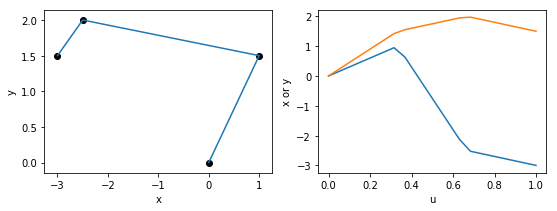

In [2]:
#Code for the below figures on piecewise linear curves
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np

def interp_piecewise_linear(qs,u):
    """Interpolates a piecewise linear curve given by the milestone list qs"""
    if u <= 0: return qs[0]
    if u >= 1: return qs[-1]
    n = len(qs)-1
    i = int(math.floor(u*n))
    s = u*n-i
    return qs[i]+s*(qs[i+1]-qs[i])

#you may play with the milestones here
milestones = np.array([(0,0),(1,1.5),(-2.5,2),(-3.0,1.5)])

#this is the plotting code
plt.figure(num=None, figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(milestones[:,0],milestones[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(milestones[:,0],milestones[:,1],c='k',linewidths=None)

plt.subplot(1, 2, 2)
us = np.linspace(0,1,20)
evaluated = np.array([interp_piecewise_linear(milestones,u) for u in us])
plt.plot(us,evaluated[:,0])
plt.plot(us,evaluated[:,1])
plt.xlabel('u')
plt.ylabel('x or y')
plt.show()

### Polynomial

Another common representation is a degree $d$ polynomial

$$ y(u) = poly(\V{c}_0,\ldots,\V{c}_d;u) = \sum_{i=0}^d \V{c}_i u^i $$

where $\V{c}_0,\ldots,\V{c}_d \in \mathcal{C}$ are the polynomial coefficients.  This is a _parametric_ representation in which each component of the motion is represented by an independent 1D function.  Hence, in 2D the y component of a curve may not be, in general, a proper function of x, even though both x and y are proper functions of u.

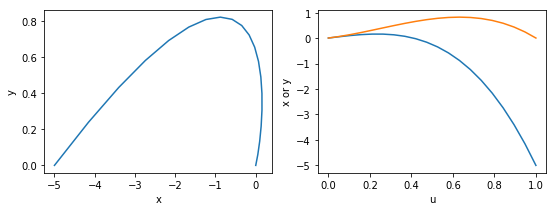

In [3]:
#Code for the figure below, showing the parametric nature of multivariate polynomial curves
from numpy.polynomial import polynomial

def interp_polynomial(cs,u):
    """Interpolates a piecewise linear curve given by the coefficient list cs"""
    return polynomial.polyval(u,cs)

#you may play with the coefficients here
coeffs = np.array([(0,0),(1,1),(0,3.0),(-6,-4.0)])

us = np.linspace(0,1,20)
evaluated = np.array([interp_polynomial(coeffs,u) for u in us])

#this is the plotting code
plt.figure(num=None, figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(evaluated[:,0],evaluated[:,1])
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.plot(us,evaluated[:,0])
plt.plot(us,evaluated[:,1])
plt.xlabel('u')
plt.ylabel('x or y')
plt.show()

A polynomial is infinitely smooth, but in order to represent complex paths, the polynomial must be of high degree.  High degree polynomials often lead to numerical instability, in which small changes to the highest degree terms cause the curve to change wildly.  The coefficients are also difficult to choose, as they can be fairly intuitive.

### Splines

Splines are a cross between polynomials and piecewise linear curves that gives the "best of both worlds" in terms of the flexibility of piecewise linear curves but also the smoothness qualities of polynomials.  They consist of a sequence of piecewise polynomials, all of low degree.  The representation of the path is given by a set of _control points_ which control the shape of the curve. From these points, polynomial coefficients are derived in order to enforce continuity.

The general form of a spline with $n$ segments and degree $d$ is given as follows

$$y(u) = poly(C_i;un-i)$$

where $i=\lfloor un \rfloor$ is the segment index and $C_i=(\V{c}_{0,i},...,\V{c}_{d,i})$ is the set of polynomial coefficients for the $i$th segment.  We do not typically store the polynomial coefficients themselves, but instead represent a list of control points $\V{p}_1,\ldots,\V{p}_k$ from which the coefficients of each polynomial are derived.  This is because it is difficult to set up coefficients manually such that the spline is continuous and smooth.  Modifying control points is far easier and more intuitive.  The method for converting control points to coefficients is the _interpolation scheme_.

Typical splines are degree 3 or 5, which are known as cubic or quintic splines, respectively.  (Degree 1 splines are actually piecewise linear curves.) These degrees are popular because they allow control point interpolation schemes to dictate the order of the spline's smoothness (derivative continuity).

#### Cubic Hermite splines

The simplest spline is the cubic Hermite spline, which defines the control points to include milestones and the derivative of the spline at each milestones.  The Hermite interpolation scheme solves for the polynomials to enforce continuity and derivative continuity (C1 continuity).

#### Quintic Hermite splines

The quintic Hermite spline defines control points to include milestones and their 1st and second derivatives. The interpolation scheme enforcse continuity of first and second derivatives (C2 continuity).